# Deal or No Deal

## Technical Analysis Based LSTM Pricing Model

### Dependency

In [531]:
import os
import glob
import random
from pathlib import Path
from datetime import datetime
from enum import Enum

import matplotlib
%matplotlib inline

import collections
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

from torch import nn
import torch.tensor
import torch.optim as optim
import torch.nn.functional as F

from talib import RSI, BBANDS, ADOSC

from sklearn.preprocessing import MinMaxScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.mode.chained_assignment = None

### Configs

In [566]:
DATE_BEGIN = datetime.strptime('1998-01-01', '%Y-%m-%d')

TRAINING_DATE_TO = datetime.strptime('2019-06-30', '%Y-%m-%d')

VALIDATION_DATE_FROM = datetime.strptime('2019-07-01', '%Y-%m-%d')
VALIDATION_DATE_TO = datetime.strptime('2019-12-31', '%Y-%m-%d')

TESTING_DATE_FROM = datetime.strptime('2020-01-01', '%Y-%m-%d')
TESTING_DATE_TO = datetime.strptime('2020-02-13', '%Y-%m-%d')

In [567]:
DATA_DIR = '..'
REGION = 'us'
INSTRUMENT = 'unh'

RAW_DATA_FULL_FEATURES_SET = ['date', 'open', 'high', 'low', 'close', 'volume', 'openint']
RAW_DATA_REMOVED_FEATURES_SET = ['open', 'high', 'low', 'close']
RAW_DATA_ADDED_FEATURES_SET = ['volume']
RAW_DATA_FEATURES_SET = RAW_DATA_REMOVED_FEATURES_SET + RAW_DATA_ADDED_FEATURES_SET

RAW_DATA_FEATURES_SET = ['open', 'high', 'low', 'close', 'volume']
RAW_TARGET = 'close'

FEATURES_SET = ['open',
                'high',
                'low',
                'close',
                'volume',
#                 'ta_bbands_up',
#                 'ta_bbands_mid',
#                 'ta_bbands_low',
#                 'ta_osc_ad'
               ]
TARGET = 'close_delta'

EXECLUDE_FIELDS = ['date', 'openint', 'close_t1']

## Helpers

### Market Data

In [568]:
def fetch_instrument_file(instrument, region, base_dir):
    cwd = os.getcwd()
    os.chdir(base_dir)
    
    instrument_file_list = result = list(Path('.').rglob(f"*{instrument}*.txt"))
    if not instrument_file_list:
        os.chdir(cwd)
        raise Exception(f'Cannot find file for instrument {instrument}')
    if len(instrument_file_list) > 1:
        os.chdir(cwd)
        raise Exception(f'Found multiple file for instrument {instrument}')
        
    os.chdir(cwd)
    return str(os.path.normpath(
                    os.path.join(os.getcwd(), base_dir, instrument_file_list[0])
                )
            )

instrument_data_file = fetch_instrument_file(INSTRUMENT, REGION, DATA_DIR)
instrument_data_file

'/Users/myousse3/data/dev/personal/dealnodeal/data/prices/daily/us/nyse stocks/2/unh.us.txt'

# Data Preparation 

In [569]:
instrument_data_file = fetch_instrument_file(INSTRUMENT, REGION, DATA_DIR)
instrument_data_file

'/Users/myousse3/data/dev/personal/dealnodeal/data/prices/daily/us/nyse stocks/2/unh.us.txt'

In [570]:
df = pd.read_csv(instrument_data_file)
df.columns = RAW_DATA_FULL_FEATURES_SET

df.date = pd.to_datetime(df.date, format='%Y%m%d')
df['volume'] = df['volume'].astype('float64')
df

,date,open,high,low,close,volume,openint
0,1990-03-26,0.25264,0.25264,0.25264,0.25264,473990.0,0
1,1990-03-27,0.25264,0.26996,0.25264,0.26996,4493732.0,0
2,1990-03-28,0.26996,0.26996,0.26119,0.26119,1793083.0,0
3,1990-03-29,0.26996,0.26996,0.26119,0.26119,617291.0,0
4,1990-03-30,0.26996,0.26996,0.26119,0.26119,2017221.0,0
...,...,...,...,...,...,...,...
7510,2020-01-16,298.00000,300.99000,295.93000,300.74000,3710344.0,0
7511,2020-01-17,300.01000,300.70000,295.88000,298.47000,4632160.0,0
7512,2020-01-21,296.89000,302.54000,296.01000,300.53000,4963132.0,0
7513,2020-01-22,301.99000,302.13000,297.35000,300.59000,3117568.0,0


In [571]:
class features_extraction_ops(Enum):
    calc_features_X = 'calc_features_X'
    calc_target_y = 'calc_target_y'
    
    clean = 'clean'
    
    statistics = 'statistics'
    normalize = 'normalize'
    
    profile = 'profile'

def features_extraction(df, ops = []):
    def _calc_feature_X(df):
        target_field_values = df[RAW_TARGET].values
        df['ta_bbands_up'], df['ta_bbands_mid'], df['ta_bbands_low'] = BBANDS(target_field_values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        
        high = df['high'].values
        low = df['low'].values
        close = df['close'].values
        volume = df['volume'].values
        df['ta_osc_ad'] = ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
        return df
    
    def _calc_target_y(df):
        df[f'{RAW_TARGET}_t1'] = df[RAW_TARGET].shift(-1)
        df[f'{RAW_TARGET}_delta'] = df[f'{RAW_TARGET}_t1'] - df[RAW_TARGET]
        return df
    
    def _clean(df):
        df.dropna(inplace=True)
        return df

    def _statistics(df):
        return df.describe()
    
    def _normalize(df):
        for feature in df.columns:
            if feature == 'date':
                continue    
            df[feature] = MinMaxScaler().fit_transform(df[[feature]])        
        return df
    
    def _profile(df):
        return ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})

    if features_extraction_ops.calc_features_X in ops:
        df = _calc_feature_X(df)
    elif features_extraction_ops.calc_target_y in ops:
        df = _calc_target_y(df)
    elif features_extraction_ops.clean in ops:
        df = _clean(df)
    elif features_extraction_ops.statistics in ops:
        df = _statistics(df)
    elif features_extraction_ops.normalize in ops:
        df = _normalize(df)
    elif features_extraction_ops.profile in ops:
        return _profile(df)
        
    return df


In [572]:
df = features_extraction(df, [features_extraction_ops.calc_features_X])
df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad
0,1990-03-26,0.25264,0.25264,0.25264,0.25264,473990.0,0,NaN,NaN,NaN,NaN
1,1990-03-27,0.25264,0.26996,0.25264,0.26996,4493732.0,0,NaN,NaN,NaN,NaN
2,1990-03-28,0.26996,0.26996,0.26119,0.26119,1793083.0,0,NaN,NaN,NaN,NaN
3,1990-03-29,0.26996,0.26996,0.26119,0.26119,617291.0,0,NaN,NaN,NaN,NaN
4,1990-03-30,0.26996,0.26996,0.26119,0.26119,2017221.0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7510,2020-01-16,298.00000,300.99000,295.93000,300.74000,3710344.0,0,299.892621,293.4530,287.013379,3.389359e+06
7511,2020-01-17,300.01000,300.70000,295.88000,298.47000,4632160.0,0,300.523508,293.7315,286.939492,3.742261e+06
7512,2020-01-21,296.89000,302.54000,296.01000,300.53000,4963132.0,0,301.434302,294.0270,286.619698,4.153429e+06
7513,2020-01-22,301.99000,302.13000,297.35000,300.59000,3117568.0,0,302.328248,294.4270,286.525752,4.296836e+06


In [573]:
df = features_extraction(df, [features_extraction_ops.calc_target_y])
df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
0,1990-03-26,0.25264,0.25264,0.25264,0.25264,473990.0,0,NaN,NaN,NaN,NaN,0.26996,0.01732
1,1990-03-27,0.25264,0.26996,0.25264,0.26996,4493732.0,0,NaN,NaN,NaN,NaN,0.26119,-0.00877
2,1990-03-28,0.26996,0.26996,0.26119,0.26119,1793083.0,0,NaN,NaN,NaN,NaN,0.26119,0.00000
3,1990-03-29,0.26996,0.26996,0.26119,0.26119,617291.0,0,NaN,NaN,NaN,NaN,0.26119,0.00000
4,1990-03-30,0.26996,0.26996,0.26119,0.26119,2017221.0,0,NaN,NaN,NaN,NaN,0.26996,0.00877
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7510,2020-01-16,298.00000,300.99000,295.93000,300.74000,3710344.0,0,299.892621,293.4530,287.013379,3.389359e+06,298.47000,-2.27000
7511,2020-01-17,300.01000,300.70000,295.88000,298.47000,4632160.0,0,300.523508,293.7315,286.939492,3.742261e+06,300.53000,2.06000
7512,2020-01-21,296.89000,302.54000,296.01000,300.53000,4963132.0,0,301.434302,294.0270,286.619698,4.153429e+06,300.59000,0.06000
7513,2020-01-22,301.99000,302.13000,297.35000,300.59000,3117568.0,0,302.328248,294.4270,286.525752,4.296836e+06,299.46000,-1.13000


In [574]:
df = features_extraction(df, [features_extraction_ops.clean])
df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
19,1990-04-23,0.26996,0.26996,0.26119,0.26996,1146400.0,0,0.293380,0.273881,0.254381,1.746690e+06,0.26996,0.00000
20,1990-04-24,0.26996,0.27862,0.26996,0.26996,804683.0,0,0.291778,0.274747,0.257715,1.447426e+06,0.27862,0.00866
21,1990-04-25,0.26996,0.27862,0.26996,0.27862,870823.0,0,0.292142,0.275180,0.258217,1.470496e+06,0.27862,0.00000
22,1990-04-26,0.27862,0.28748,0.27862,0.27862,1410954.0,0,0.291796,0.276051,0.260306,8.973120e+05,0.26996,-0.00866
23,1990-04-27,0.27862,0.27862,0.26996,0.26996,2167868.0,0,0.290995,0.276490,0.261984,-1.085223e+05,0.29624,0.02628
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7509,2020-01-15,289.02000,299.64000,289.00000,296.41000,6081615.0,0,298.558537,292.939500,287.320463,2.042606e+06,300.74000,4.33000
7510,2020-01-16,298.00000,300.99000,295.93000,300.74000,3710344.0,0,299.892621,293.453000,287.013379,3.389359e+06,298.47000,-2.27000
7511,2020-01-17,300.01000,300.70000,295.88000,298.47000,4632160.0,0,300.523508,293.731500,286.939492,3.742261e+06,300.53000,2.06000
7512,2020-01-21,296.89000,302.54000,296.01000,300.53000,4963132.0,0,301.434302,294.027000,286.619698,4.153429e+06,300.59000,0.06000


In [575]:
df_summary = features_extraction(df, [features_extraction_ops.statistics])
df_summary

,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
count,7495.000000,7495.000000,7495.000000,7495.000000,7.495000e+03,7495.0,7495.000000,7495.000000,7495.000000,7.495000e+03,7495.000000,7495.000000
mean,50.104167,50.598355,49.590174,50.112846,8.569760e+06,0.0,52.136497,49.739066,47.341635,5.026231e+05,50.152764,0.039919
std,67.410059,67.970985,66.787165,67.408411,7.244469e+06,0.0,69.733003,66.830180,63.985451,6.539407e+06,67.467454,1.185806
min,0.269960,0.269960,0.261190,0.269960,0.000000e+00,0.0,0.290995,0.273881,0.242782,-4.709024e+07,0.269960,-12.690000
25%,5.634700,5.721900,5.565000,5.643600,4.479024e+06,0.0,6.033469,5.619700,5.137624,-2.356553e+06,5.643600,-0.169500
50%,24.654000,25.159000,24.221000,24.726000,6.802150e+06,0.0,26.546813,24.378600,22.553876,7.127590e+05,24.726000,0.008700
75%,50.272000,50.767000,49.738500,50.252000,1.039108e+07,0.0,52.209319,50.123725,47.797364,3.836386e+06,50.279000,0.236000
max,301.990000,302.540000,297.350000,300.740000,1.858094e+08,0.0,302.328248,294.427000,287.322510,3.706736e+07,300.740000,17.930000


In [576]:
# df_profiler = features_extraction(df, [features_extraction_ops.profile])
# df_profiler

In [577]:
df = features_extraction(df, [features_extraction_ops.normalize])
df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
19,1990-04-23,0.000000,0.000000,0.000000,0.000000,0.006170,0.0,0.000008,0.000000,0.000040,0.580303,0.000000,0.414435
20,1990-04-24,0.000000,0.000029,0.000030,0.000000,0.004331,0.0,0.000003,0.000003,0.000052,0.576747,0.000029,0.414718
21,1990-04-25,0.000000,0.000029,0.000030,0.000029,0.004687,0.0,0.000004,0.000004,0.000054,0.577021,0.000029,0.414435
22,1990-04-26,0.000029,0.000058,0.000059,0.000029,0.007594,0.0,0.000003,0.000007,0.000061,0.570211,0.000000,0.414152
23,1990-04-27,0.000029,0.000029,0.000030,0.000000,0.011667,0.0,0.000000,0.000009,0.000067,0.558259,0.000087,0.415293
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7509,2020-01-15,0.957013,0.990406,0.971894,0.985589,0.032730,0.0,0.987519,0.994943,0.999993,0.583819,1.000000,0.555846
7510,2020-01-16,0.986776,0.994872,0.995220,1.000000,0.019969,0.0,0.991936,0.996689,0.998923,0.599822,0.992445,0.340300
7511,2020-01-17,0.993438,0.993913,0.995052,0.992445,0.024930,0.0,0.994025,0.997636,0.998666,0.604016,0.999301,0.481711
7512,2020-01-21,0.983097,1.000000,0.995490,0.999301,0.026711,0.0,0.997040,0.998640,0.997552,0.608901,0.999501,0.416395


#### Split/Revers dataset - (Training / Validation / Testing)

In [578]:
training_df = df[(df['date'] >= DATE_BEGIN) & (df['date'] <= TRAINING_DATE_TO)] 
training_df = training_df.reset_index()
training_df.drop(['index'], axis=1, inplace=True)
training_df = training_df[::-1]
training_df

validation_df = df[(df['date'] >= DATE_BEGIN) & (df['date'] <= VALIDATION_DATE_TO)] 
validation_df = validation_df.reset_index()
validation_df.drop(['index'], axis=1, inplace=True)
validation_df = validation_df[::-1]
validation_df

testing_df = df[(df['date'] >= DATE_BEGIN) & (df['date'] <= TESTING_DATE_TO)] 
testing_df = testing_df.reset_index()
testing_df.drop(['index'], axis=1, inplace=True)
testing_df = testing_df[::-1]
testing_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5405,2019-06-28,0.809128,0.808483,0.795583,0.804273,0.036518,0.0,0.827946,0.825037,0.819694,0.546681,0.799780,0.370346
5404,2019-06-27,0.801770,0.813081,0.810629,0.811961,0.018272,0.0,0.828146,0.824484,0.818352,0.536881,0.804273,0.338994
5403,2019-06-26,0.814066,0.812849,0.810528,0.802509,0.020914,0.0,0.827638,0.823826,0.817538,0.538189,0.811961,0.507185
5402,2019-06-25,0.818342,0.822543,0.824867,0.816354,0.017277,0.0,0.827689,0.823466,0.816746,0.554690,0.802509,0.278576
5401,2019-06-24,0.825003,0.827770,0.826348,0.822878,0.017173,0.0,0.826640,0.822341,0.815544,0.565166,0.816354,0.350425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1998-01-08,0.017233,0.017431,0.017472,0.017361,0.056610,0.0,0.017564,0.017141,0.016696,0.583852,0.016985,0.410741
3,1998-01-07,0.017029,0.017258,0.017208,0.017304,0.052898,0.0,0.017655,0.017163,0.016646,0.579436,0.017361,0.414993
2,1998-01-06,0.016771,0.017086,0.016827,0.017131,0.046881,0.0,0.017812,0.017202,0.016560,0.544199,0.017304,0.416140
1,1998-01-05,0.017001,0.017201,0.017237,0.017044,0.040098,0.0,0.017931,0.017240,0.016513,0.524845,0.017131,0.415287


,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5533,2019-12-31,0.972392,0.972045,0.979131,0.977502,0.011971,0.0,0.998582,0.977053,0.951691,0.549780,0.972576,0.366101
5532,2019-12-30,0.980313,0.980150,0.986873,0.977069,0.008138,0.0,0.996751,0.974437,0.948257,0.540459,0.977502,0.418681
5531,2019-12-27,0.980180,0.980150,0.992137,0.984125,0.008327,0.0,0.994401,0.971879,0.945486,0.540933,0.977069,0.345199
5530,2019-12-26,0.977827,0.979224,0.990542,0.983060,0.005655,0.0,0.990140,0.969096,0.944267,0.535874,0.984125,0.424886
5529,2019-12-24,0.977695,0.977801,0.987243,0.979366,0.003843,0.0,0.985352,0.966490,0.943965,0.532384,0.983060,0.450686
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1998-01-08,0.017233,0.017431,0.017472,0.017361,0.056610,0.0,0.017564,0.017141,0.016696,0.583852,0.016985,0.410741
3,1998-01-07,0.017029,0.017258,0.017208,0.017304,0.052898,0.0,0.017655,0.017163,0.016646,0.579436,0.017361,0.414993
2,1998-01-06,0.016771,0.017086,0.016827,0.017131,0.046881,0.0,0.017812,0.017202,0.016560,0.544199,0.017304,0.416140
1,1998-01-05,0.017001,0.017201,0.017237,0.017044,0.040098,0.0,0.017931,0.017240,0.016513,0.524845,0.017131,0.415287


,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5547,2020-01-22,1.000000,0.998644,1.000000,0.999501,0.016778,0.0,1.000000,1.000000,0.997225,0.610605,0.995740,0.377531
5546,2020-01-21,0.983097,1.000000,0.995490,0.999301,0.026711,0.0,0.997040,0.998640,0.997552,0.608901,0.999501,0.416395
5545,2020-01-17,0.993438,0.993913,0.995052,0.992445,0.024930,0.0,0.994025,0.997636,0.998666,0.604016,0.999301,0.481711
5544,2020-01-16,0.986776,0.994872,0.995220,1.000000,0.019969,0.0,0.991936,0.996689,0.998923,0.599822,0.992445,0.340300
5543,2020-01-15,0.957013,0.990406,0.971894,0.985589,0.032730,0.0,0.987519,0.994943,0.999993,0.583819,1.000000,0.555846
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1998-01-08,0.017233,0.017431,0.017472,0.017361,0.056610,0.0,0.017564,0.017141,0.016696,0.583852,0.016985,0.410741
3,1998-01-07,0.017029,0.017258,0.017208,0.017304,0.052898,0.0,0.017655,0.017163,0.016646,0.579436,0.017361,0.414993
2,1998-01-06,0.016771,0.017086,0.016827,0.017131,0.046881,0.0,0.017812,0.017202,0.016560,0.544199,0.017304,0.416140
1,1998-01-05,0.017001,0.017201,0.017237,0.017044,0.040098,0.0,0.017931,0.017240,0.016513,0.524845,0.017131,0.415287


# Data Preparation /Training

In [579]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


def _get_ops(op):
    if op == 'avg':
        return np.mean

    raise Exception(f'Unknown operation {op}')


def _aggregate_collection(lst, op):
    if len(lst) == 0:
        return {}
    elif len(lst) == 1:
        return lst[0]
    else:
        aggrgated_values_dict = {}
        for entry in lst:
            for key, value in entry.items():
                if key in aggrgated_values_dict:
                    aggrgated_values_dict[key].append(value)
                else:
                    aggrgated_values_dict[key] = [value]

        final_aggrgated_values_dict = {}
        for key, values in aggrgated_values_dict.items():
            values = [e for e in values if e]
            final_aggrgated_values_dict[key] = op(values)

        return final_aggrgated_values_dict


def _day_aggregator_handler(dataset, **kwargs):
    length = kwargs['length']
    return dataset[0:length], dataset[length:]


def _week_aggregator_handler(dataset, **kwargs):
    return _universal_aggregator_handler(dataset, 5, **kwargs)


def _month_aggregator_handler(dataset, **kwargs):
    return _universal_aggregator_handler(dataset, 21, **kwargs)


def _quarterly_aggregator_handler(dataset, **kwargs):
    return _universal_aggregator_handler(dataset, 21 * 3, **kwargs)


def _yearly_aggregator_handler(dataset, **kwargs):
    return _universal_aggregator_handler(dataset, 21 * 12, **kwargs)


def _universal_aggregator_handler(dataset, period_range, **kwargs):
    length = kwargs['length']
    ops = _get_ops(kwargs['op'])

    if length == -1:
        return [_aggregate_collection(dataset, ops)], []

    else:
        aggregated_dataset = []

        raw_dataset = dataset[0:length]
        raw_chunked_dataset = chunks(raw_dataset, period_range)
        for week in raw_chunked_dataset:
            aggregated_dataset.append(_aggregate_collection(week, ops))

        return aggregated_dataset, dataset[length:]


def features_aggregator(dataset, features_descriptors):
    aggregated_dataset = []
    for feature_set in features_descriptors:
        index, length, handler, params = feature_set['index'], feature_set['length'], feature_set['handler'], feature_set['params']

        if length == -1:
            period_range = len(dataset)
            step_aggregated_dataset, dataset = handler(dataset, period_range, **{
                'index': index,
                'length': length,

                **params
            })
        else:
            step_aggregated_dataset, dataset = handler(dataset, **{
                'index': index,
                'length': length,

                **params
            })

        if len(step_aggregated_dataset) > 0:
            aggregated_dataset += step_aggregated_dataset

        if len(dataset) == 0:
            return aggregated_dataset

    return aggregated_dataset


def dataset_generator(df, shift_range, repeat_out):
    _features_descriptors = [
        {'index': 0, 'length': 21 * 12 * 1, 'handler': _day_aggregator_handler, 'params': {}},
        {'index': 1, 'length': 21 * 12 * 6, 'handler': _week_aggregator_handler, 'params': {'op': 'avg'}},
        {'index': 2, 'length': 21 * 12 * 6, 'handler': _month_aggregator_handler, 'params': {'op': 'avg'}},
        {'index': 3, 'length': 21 * 12 * 6, 'handler': _quarterly_aggregator_handler, 'params': {'op': 'avg'}},
        {'index': 4, 'length': 21 * 12 * 6, 'handler': _yearly_aggregator_handler, 'params': {'op': 'avg'}},
        {'index': 5, 'length': -1, 'handler': _universal_aggregator_handler, 'params': {'op': 'avg'}},
    ]

    dup_df = df.copy()
    dup_df.drop(EXECLUDE_FIELDS, axis=1, inplace=True)
    
    dataset = list(dup_df.T.to_dict().values())
    
    generated_dataset = []
    while repeat_out > 0:
        subset = features_aggregator(dataset, _features_descriptors)
        generated_dataset.append(subset)
        
        dataset = dataset[shift_range:]
        repeat_out -= 1

    return generated_dataset

In [580]:
training_df

,date,open,high,low,close,volume,openint,ta_bbands_up,ta_bbands_mid,ta_bbands_low,ta_osc_ad,close_t1,close_delta
5405,2019-06-28,0.809128,0.808483,0.795583,0.804273,0.036518,0.0,0.827946,0.825037,0.819694,0.546681,0.799780,0.370346
5404,2019-06-27,0.801770,0.813081,0.810629,0.811961,0.018272,0.0,0.828146,0.824484,0.818352,0.536881,0.804273,0.338994
5403,2019-06-26,0.814066,0.812849,0.810528,0.802509,0.020914,0.0,0.827638,0.823826,0.817538,0.538189,0.811961,0.507185
5402,2019-06-25,0.818342,0.822543,0.824867,0.816354,0.017277,0.0,0.827689,0.823466,0.816746,0.554690,0.802509,0.278576
5401,2019-06-24,0.825003,0.827770,0.826348,0.822878,0.017173,0.0,0.826640,0.822341,0.815544,0.565166,0.816354,0.350425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1998-01-08,0.017233,0.017431,0.017472,0.017361,0.056610,0.0,0.017564,0.017141,0.016696,0.583852,0.016985,0.410741
3,1998-01-07,0.017029,0.017258,0.017208,0.017304,0.052898,0.0,0.017655,0.017163,0.016646,0.579436,0.017361,0.414993
2,1998-01-06,0.016771,0.017086,0.016827,0.017131,0.046881,0.0,0.017812,0.017202,0.016560,0.544199,0.017304,0.416140
1,1998-01-05,0.017001,0.017201,0.017237,0.017044,0.040098,0.0,0.017931,0.017240,0.016513,0.524845,0.017131,0.415287


In [581]:
train_dataset = dataset_generator(training_df, shift_range=1, repeat_out=128)
print('Total seqs: ', len(train_dataset))
print('1s seq length: ', len(train_dataset[0]))
print('1s seq: ')
train_dataset[0][0]

Total seqs:  128
1s seq length:  654
1s seq: 


{'open': 0.8091276933411516,
 'high': 0.8084825078926114,
 'low': 0.7955830110194995,
 'close': 0.8042733312113247,
 'volume': 0.03651784971252828,
 'ta_bbands_up': 0.827946148210309,
 'ta_bbands_mid': 0.8250367016760466,
 'ta_bbands_low': 0.8196943909375252,
 'ta_osc_ad': 0.5466809410812797,
 'close_delta': 0.37034617896799543}

In [582]:
def pad_dataset_sequence(dataset):
    if len(dataset) == 0:
        return dataset

    max_sequence = max([len(e) for e in dataset])

    input_example_dict = dataset[0][0]
    pad_example_dict = {k: 0.0 for k, _ in input_example_dict.items()}

    for example in dataset:
        residual_sequence_length = max_sequence - len(example)
        if residual_sequence_length > 0:
            for e in [pad_example_dict] * residual_sequence_length:
                example.append(e)

    return dataset

print('Sequences length freq table (before padding)', collections.Counter([len(e) for e in train_dataset]), sep='\n')
train_dataset = pad_dataset_sequence(train_dataset)
print('Sequences length freq table (after padding)', collections.Counter([len(e) for e in train_dataset]), sep='\n')

Sequences length freq table (before padding)
Counter({654: 114, 653: 14})
Sequences length freq table (after padding)
Counter({654: 128})


# Data Preparation /Validation

In [583]:
validation_subset_df = df[(df['date'] >= VALIDATION_DATE_FROM) & (df['date'] <= VALIDATION_DATE_TO)]
validation_dataset_size = len(validation_subset_df.index)
print('Validation dataset size: ', validation_dataset_size)

Validation dataset size:  128


In [584]:
validation_dataset = dataset_generator(validation_df, shift_range=1, repeat_out=validation_dataset_size)
print('Total seqs: ', len(train_dataset))
print('1s seq length: ', len(train_dataset[0]))
print('1s seq: ')
train_dataset[0][0]

Total seqs:  128
1s seq length:  654
1s seq: 


{'open': 0.8091276933411516,
 'high': 0.8084825078926114,
 'low': 0.7955830110194995,
 'close': 0.8042733312113247,
 'volume': 0.03651784971252828,
 'ta_bbands_up': 0.827946148210309,
 'ta_bbands_mid': 0.8250367016760466,
 'ta_bbands_low': 0.8196943909375252,
 'ta_osc_ad': 0.5466809410812797,
 'close_delta': 0.37034617896799543}

# Modeling

### Hyper-parameters

In [ ]:
class HyperParams:
    
    class Training:
        epochs = 10
        batch_size = 1
        learning_rate = 0.01
        
    class Model:
        class LSTM:
            input_size = len(FEATURES_SET)
            sequence_size = len(train_dataset[0])
            layers_size = 1
            hidden_size = 128
            dropout_rate = 0.05

        class Dense:
            layer_1 = 1024
            layer_2 = 1024
            layer_3 = 1024

            dropout = 0.05

            input_size = 128
            output_size = 1
            
gpu_enabled = torch.cuda.is_available()
device = torch.device("cuda") if gpu_enabled else torch.device("cpu")


In [ ]:
class InstrumentLSTMMPriceIndicatorNN(nn.Module):

    def __init__(self):
        super(InstrumentLSTMMPriceIndicatorNN, self).__init__()

        self._lstm = nn.LSTM(input_size=HyperParams.Model.LSTM.input_size, 
                             hidden_size=HyperParams.Model.LSTM.hidden_size, 
                             num_layers=HyperParams.Model.LSTM.layers_size, 
                             batch_first=True)
        
        self._fc_1 = nn.Linear(HyperParams.Model.Dense.input_size, HyperParams.Model.Dense.layer_1)
        self._fc_2 = nn.Linear(HyperParams.Model.Dense.layer_1, HyperParams.Model.Dense.layer_2)
        self._fc_3 = nn.Linear(HyperParams.Model.Dense.layer_2, HyperParams.Model.Dense.layer_3)
        self._fc_4 = nn.Linear(HyperParams.Model.Dense.layer_3, HyperParams.Model.Dense.output_size)

        self._drop_layer = nn.Dropout(p=HyperParams.Model.Dense.dropout)

    def forward(self, input):
        batch_size = input.size(0)

        hidden = self.init_hidden(batch_size)
        out, hidden = self._lstm(input.double(), hidden)

        out = hidden[0][-1].view(batch_size, -1)
        
        out = (F.relu(self._fc_1(out)))
        out = (F.relu(self._fc_2(out)))
        out = (F.relu(self._fc_3(out)))
        out = self._fc_4(out)


    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(HyperParams.Model.LSTM.layers_size, 
                             batch_size, 
                             HyperParams.Model.LSTM.hidden_size).zero_().double(),
                  weight.new(HyperParams.Model.LSTM.layers_size, 
                             batch_size, HyperParams.Model.LSTM.hidden_size).zero_().double())
        return hidden
    

## Training

In [ ]:
model = InstrumentLSTMMPriceIndicatorNN().double()
print(model)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=HyperParams.Training.learning_rate)

if gpu_enabled:
    model.cuda()
    print('GPU Enabled Model')
else:
    print('GPU Disabled Model')

In [ ]:
def tensorify_example(example):
    example_df = pd.DataFrame(example)

    features_tensor = torch.tensor(example_df[FEATURES_SET].values, dtype=torch.double)
    features_tensor = features_tensor.unsqueeze(0)

    target_tensor = torch.tensor(example_df[TARGET].values[0], dtype=torch.double)
    target_tensor = target_tensor.view(1, -1)

    #  features_tensor.size() # torch.Size([1, 658, 7])
    # target_tensor.size() # torch.Size([1, 658])
    return features_tensor, target_tensor


def batch_tensorify(examples_batch):
    features_tensors_list = [tensorify_example(example)[0] for example in examples_batch]
    target_tensors_list = [tensorify_example(example)[1] for example in examples_batch]

    return torch.cat(features_tensors_list, 0), torch.cat(target_tensors_list, 0)


exmaple_1 = train_dataset[0]
exmaple_2 = train_dataset[1]
batch_features, batch_target = batch_tensorify([exmaple_1, exmaple_2])

batch_features.size()
batch_features

batch_target.size()
batch_target

In [ ]:

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

            
total_loss = 10^1000
for epoch in range(1, HyperParams.Training.epochs + 1):
    
    epoch_loss = 0.0
    for batch_examples in batch(train_dataset, HyperParams.Training.batch_size):

        batch_features, batch_target = batch_tensorify(batch_examples)
        batch_features, batch_target = batch_features.double(), batch_target.double()

        if gpu_enabled:
            batch_features = batch_features.cuda()
            batch_target = batch_target.cuda()

        output = model(batch_features.double())

        loss = criterion(output, batch_target)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        
    if epoch_loss < total_loss:
        torch.save(model.state_dict(), f'./{INSTRUMENT}_{HyperParams.Training.epochs}epochs_model_state.pt')
        print('Save model checkpoint', f'./{INSTRUMENT}_{HyperParams.Training.epochs}epochs_model_state.pt')
        total_loss = epoch_loss

    print(f'Epoch: {epoch}/{HyperParams.Training.epochs} ............. Loss: {epoch_loss/HyperParams.Training.epochs}')

# Evaludation

#### Load model

In [561]:
model = InstrumentLSTMMPriceIndicatorNN().double()
model.load_state_dict(torch.load(f'./{INSTRUMENT}_{HyperParams.Training.epochs}epochs_model_state.pt'))
model.eval()

<All keys matched successfully>

InstrumentLSTMMPriceIndicatorNN(
  (_lstm): LSTM(9, 128, num_layers=2, batch_first=True)
  (_fc): Linear(in_features=128, out_features=1, bias=True)
)

#### Prepare data

In [562]:
testing_subset_df = df[(df['date'] >= TESTING_DATE_FROM) & (df['date'] <= TESTING_DATE_TO)]
testing_dataset_size = len(testing_subset_df.index)
print('Testing dataset size: ', testing_dataset_size)

Testing dataset size:  14


In [563]:
testing_dataset = dataset_generator(testing_df, shift_range=1, repeat_out=testing_dataset_size)
print('Total seqs: ', len(testing_dataset))
print('1s seq length: ', len(testing_dataset[0]))
print('1s seq: ')
testing_dataset[0][0]

Total seqs:  14
1s seq length:  655
1s seq: 


{'open': 1.0000000000000002,
 'high': 0.9986435969638273,
 'low': 0.9999999999999999,
 'close': 0.9995007821744889,
 'volume': 0.016778310906508626,
 'ta_bbands_up': 1.0000000000000002,
 'ta_bbands_mid': 1.0,
 'ta_bbands_low': 0.9972246107772222,
 'ta_osc_ad': 0.6106053063030904,
 'close_delta': 0.37753102547354733}

In [564]:

expected = []
actual = []

with torch.no_grad():

    for examples in testing_dataset:
        features, target = batch_tensorify([examples])
        features, target = features.double(), target.double()

        if gpu_enabled:
            features = features.cuda()
            target = target.cuda()

        output = model(features.double())

        actual.append(output[0][0].item())
        expected.append(target[0][0].item())

print(actual)
print(expected)

[0.2825684183971086, 0.2827333418259428, 0.282764257401899, 0.282555659818821, 0.28183919439172345, 0.28183463121346325, 0.28183302726129333, 0.28183278696416725, 0.28183557555224636, 0.2818392534061594, 0.2818384463415574, 0.2818359878927326, 0.281830283623555, 0.28181822861639194]
[0.37753102547354733, 0.4163945133899417, 0.48171129980404825, 0.340300457217506, 0.5558458523840625, 0.6812540822991515, 0.49248856956237747, 0.11136512083605649, 0.4441541476159367, 0.359568909209669, 0.6139777922926181, 0.35695623775310337, 0.480078380143697, 0.3177661659046387]


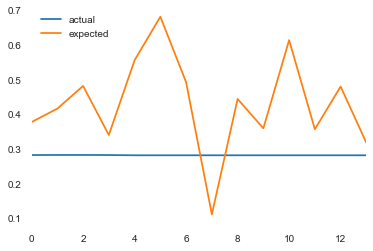

In [565]:
testing_result_df = pd.DataFrame({'actual':actual, 'expected':expected})
testing_result_df.plot()